In [ ]:
# Show plots inline, and load main getdist plot module and samples class
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import scipy.linalg as la
import pandas as pd
from pandas import read_table
import os,sys
import sys, os
from getdist import plots, MCSamples
import getdist
import matplotlib.pyplot as plt
import IPython

try:
    from cobaya.likelihood import Likelihood
    print('Importiong EE_like as cobaya likelihood')
except:
    class Likelihood:  # dummy class to inherit if cobaya is missing
        print('dummy class to inherit')
        pass

Importiong EE_like as cobaya likelihood


In [ ]:
class Like_EE(Likelihood):
    
    name: str = "Like-EE"
    
    def initialize(self):

        like_path=os.getcwd()
        self.path_EE = like_path + '/EE.txt'
        
        #Reading data
        self.data = pd.read_csv(self.path_EE, sep='\t')
        self.ell=self.data.iloc[:,0]
        self.EE=self.data.iloc[:,1]
        self.err_plus=self.data.iloc[:,2]
        self.err_min=self.data.iloc[:,3]
        
        self.sigma=np.zeros(len(self.EE))
        
        for j in range(len(self.EE)):
            
            self.sigma[j]=max(self.err_plus[j],self.err_min[j])

        
    def get_requirements(self):
        """
         return dictionary specifying quantities calculated by a theory code are needed
        """
        reqs = {'C':None}

        return reqs
    
    
    def logp(self, **params_values): 
        
        C = self.provider.get_param("C")
        
        self.A=np.zeros(len(self.EE))
        
        for i in range(len(self.EE)):
            
            self.A[i]= (self.EE[i]-C)**2 / self.sigma[i]**2
        
        chi2=np.sum(self.A)
        
        return -0.5 * chi2
        

In [3]:
guess=[0.05]
C= guess

info = {"likelihood": {"Like-EE": Like_EE}} 

from collections import OrderedDict as odict

info["params"] = odict([
["C", {"prior": {"min":-1, "max":1},"ref":0.1,"proposal": 0.05,"latex": r"C"}]
])

#Settings to start the MCMC chain # Gelman-Rubin test accuracy
info["sampler"] = {
"mcmc": {"burn_in": 300, "max_samples": 10000000, "Rminus1_stop": 0.0001,
         "Rminus1_cl_stop": 0.2, "learn_proposal": True, "max_tries": np.inf}}

#load the settings defined in cobaya
from cobaya.run import run

updated_info, products = run(info)

[mcmc] Getting initial point... (this may take a few seconds)
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {Like-EE: 28500.0}
[mcmc] Initial point: C:0.1
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Sampling! (NB: no accepted step will be saved until 300 burn-in samples have been obtained)
[mcmc] Progress @ 2023-11-11 18:03:17 : 1 steps taken -- still burning in, 300 accepted steps left.
[mcmc] Finished burn-in phase: discarded 300 accepted steps.
[mcmc] Learn + convergence test @ 40 samples accepted.
[mcmc]  - Acceptance rate: 0.034
[mcmc]  - Convergence of means: R-1 = 0.246278 after 32 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 80 samples accepted.
[mcmc]  - Acceptance rate: 0.093
[mcmc]  - Convergence of means: R-1 = 0.101765 after 64 accepted steps
[mcmc]  - Upda

[root] *WARNING* auto bandwidth for chi2 very small or failed (h=0.00033230618058315535,N_eff=4272.038392148373). Using fallback (h=0.0032376441401984644)


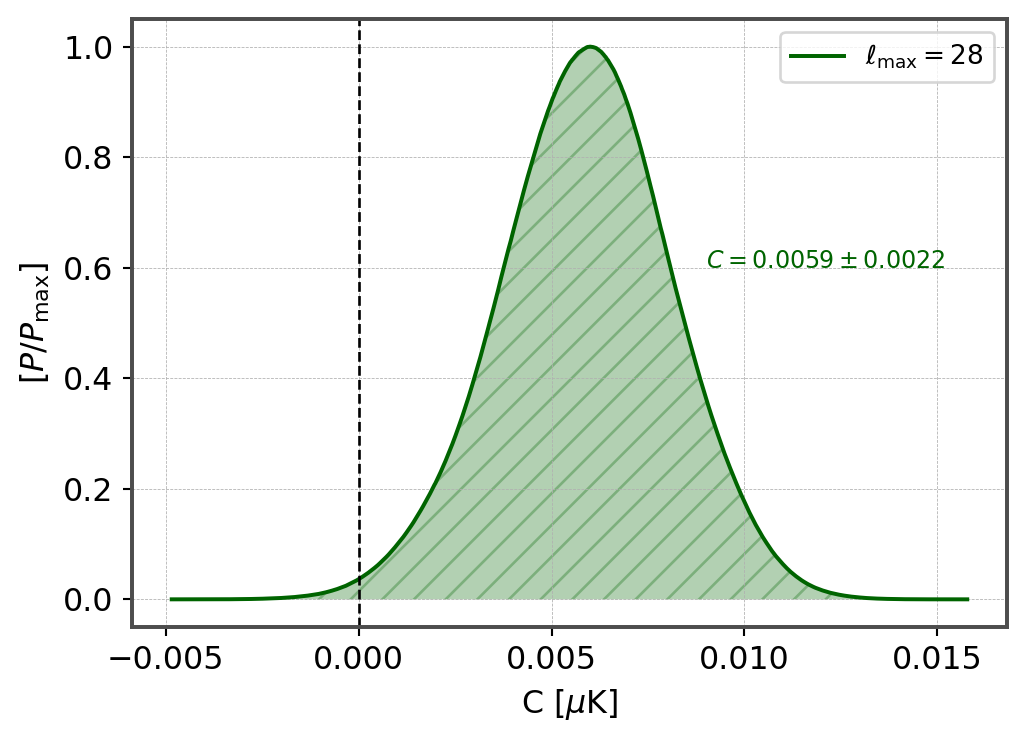

In [4]:
from getdist.mcsamples import MCSamplesFromCobaya
import getdist.plots as gdplt

gdsamples = MCSamplesFromCobaya(updated_info, products.products()["sample"],ignore_rows=0.3)

#g = plots.get_single_plotter(width_inch=4)
#g.plot_1d([gdsamples,gdsamples_2],'C')

C=gdsamples.get1DDensity('C').x
P=gdsamples.get1DDensity('C').P


plt.rcParams["axes.edgecolor"] = "0.3"
plt.rcParams["axes.linewidth"]  = "1.5"
plt.rcParams["ytick.labelsize"]  = "12"
plt.rcParams["xtick.labelsize"]  = "12"
plt.rcParams["axes.titlesize"]  = "12"
plt.rcParams["figure.figsize"] = [5.5, 4]
plt.rcParams["figure.dpi"] = 95
plt.rcParams["figure.autolayout"] = True

plt.grid('--',lw=0.3, ls='--')

plt.ylabel(r"$[P/P_{\rm{max}}]$", fontsize = 12,rotation=90)
plt.xlabel(r"C [$\mu$K]", fontsize = 12,rotation=0)

plt.plot(C, P,color='Darkgreen', label=r'$\ell_{\rm max}=28$')
plt.fill_between(C, P, facecolor='Darkgreen', hatch="//", edgecolor='Darkgreen',alpha=0.3, linewidth=.01)

plt.axvline(0,c='k',ls='--',lw=1)

result_full='$'+gdsamples.getInlineLatex('C',limit=1)+'$'

plt.text(x=0.009,y=0.6,s=result_full,c='Darkgreen',size=9)

plt.legend()